In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [18]:
# Read the CSV file
ball_df = pd.read_csv('../data/raw/ball_positions.csv')

print(ball_df.columns)

Index(['Frame', ' ball_x', ' ball_y', ' is_interpolated'], dtype='object')


In [19]:
# Strip leading/trailing spaces from column names
ball_df.columns = ball_df.columns.str.strip()

# Debugging: Print the cleaned column names
print("Cleaned Columns:", ball_df.columns)

# Create a column to identify interpolated rows
ball_df["is_interpolated"] = ball_df["ball_x"].isna() | ball_df["ball_y"].isna()

# Interpolate missing X and Y values
ball_df[['ball_x', 'ball_y']] = ball_df[['ball_x', 'ball_y']].interpolate(limit_direction='both')

# Drop rows where X or Y are still NaN
ball_df = ball_df.dropna(subset=['ball_x', 'ball_y'])

# Convert X and Y to float32
ball_df[['ball_x', 'ball_y']] = ball_df[['ball_x', 'ball_y']].astype('float32')

# Check result
print("After interpolation:")
print(ball_df.head(150))

# Save cleaned version (optional)
ball_df.to_csv("../data/results/ball_positions_interpolated.csv", index=False)

Cleaned Columns: Index(['Frame', 'ball_x', 'ball_y', 'is_interpolated'], dtype='object')
After interpolation:
     Frame       ball_x      ball_y  is_interpolated
0        0  1624.500000  492.000000            False
1        1  1652.000000  501.000000            False
2        2  1655.000000  496.000000            False
3        3  1542.000000  393.500000            False
4        4  1540.000000  392.500000            False
..     ...          ...         ...              ...
145    145   423.444458  673.666687             True
146    146   380.666656  653.000000             True
147    147   337.888885  632.333313             True
148    148   295.111115  611.666687             True
149    149   252.333328  591.000000             True

[150 rows x 4 columns]


C:\Users\pedro\AppData\Local\Temp\ipykernel_13644\985250982.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("winter")  # Green to blue gradient


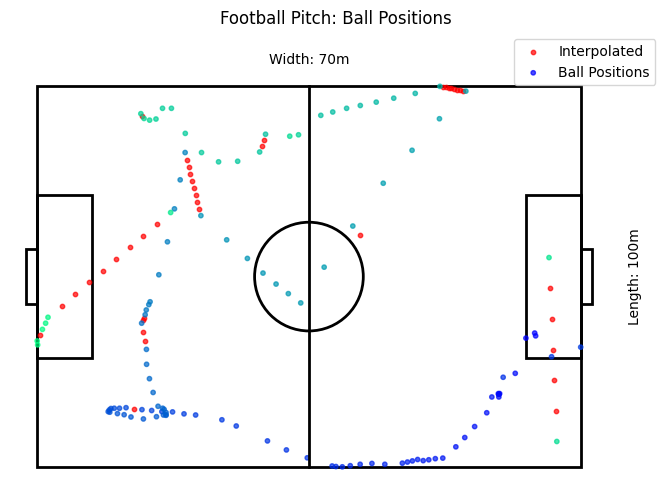

In [21]:
# Load the interpolated ball positions
ball_df = pd.read_csv("../data/results/ball_positions_interpolated.csv")

# Function to draw the football pitch
def draw_pitch(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Pitch Outline
    pitch = patches.Rectangle([0, 0], 1, 0.7, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(pitch)
    
    # Center Circle
    center_circle = patches.Circle([0.5, 0.35], 0.1, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(center_circle)
    
    # Halfway Line
    ax.plot([0.5, 0.5], [0, 0.7], color="black", lw=2)
    
    # Penalty Areas
    penalty_area_left = patches.Rectangle([0, 0.2], 0.1, 0.3, edgecolor="black", facecolor="none", lw=2)
    penalty_area_right = patches.Rectangle([0.9, 0.2], 0.1, 0.3, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(penalty_area_left)
    ax.add_patch(penalty_area_right)
    
    # Goals
    goal_left = patches.Rectangle([-0.02, 0.3], 0.02, 0.1, edgecolor="black", facecolor="none", lw=2)
    goal_right = patches.Rectangle([1, 0.3], 0.02, 0.1, edgecolor="black", facecolor="none", lw=2)
    ax.add_patch(goal_left)
    ax.add_patch(goal_right)
    
    # Add field dimensions as labels (moved to the side)
    ax.text(1.1, 0.35, "Length: 100m", ha="center", va="center", fontsize=10, color="black", rotation=90)
    ax.text(0.5, 0.75, "Width: 70m", ha="center", va="center", fontsize=10, color="black")
        
    # Set limits and aspect
    ax.set_xlim(-0.05, 1.15)  # Adjusted to fit the length label
    ax.set_ylim(-0.05, 0.8)   # Adjusted to fit the width label
    ax.set_aspect("equal")
    ax.axis("off")
    return ax

# Normalize positions to fit within the pitch dimensions
ball_df["pitch_ball_x"] = (ball_df["ball_x"] - ball_df["ball_x"].min()) / (ball_df["ball_x"].max() - ball_df["ball_x"].min())
ball_df["pitch_ball_y"] = (ball_df["ball_y"] - ball_df["ball_y"].min()) / (ball_df["ball_y"].max() - ball_df["ball_y"].min()) * 0.7

# Generate a colormap for the gradient
cmap = plt.cm.get_cmap("winter")  # Green to blue gradient
colors = cmap(np.linspace(0, 1, len(ball_df)))

# Plot the football pitch and positions
ax = draw_pitch()

# Plot interpolated positions in red
interpolated_positions = ball_df[ball_df["is_interpolated"]]
ax.scatter(interpolated_positions["pitch_ball_x"], interpolated_positions["pitch_ball_y"], 
           color="red", label="Interpolated", alpha=0.7, s=10)

# Plot the rest of the positions with gradient colors
non_interpolated_positions = ball_df[~ball_df["is_interpolated"]]
ax.scatter(non_interpolated_positions["pitch_ball_x"], non_interpolated_positions["pitch_ball_y"], 
           color=colors[~ball_df["is_interpolated"]], label="Ball Positions", alpha=0.7, s=10)

# Add legend and title
ax.legend(loc="upper right")
ax.set_title("Football Pitch: Ball Positions")

plt.show()